In [1]:
import dngo_v1
from util.plotting import visualize_dataset, visualize_predictions, visualize_EI
from util.prepare_data import f, get_toy_dataset

import torch
import numpy as np
import tqdm
from scipy.stats import norm
from importlib import reload as R

## 1. Preparing the dataset

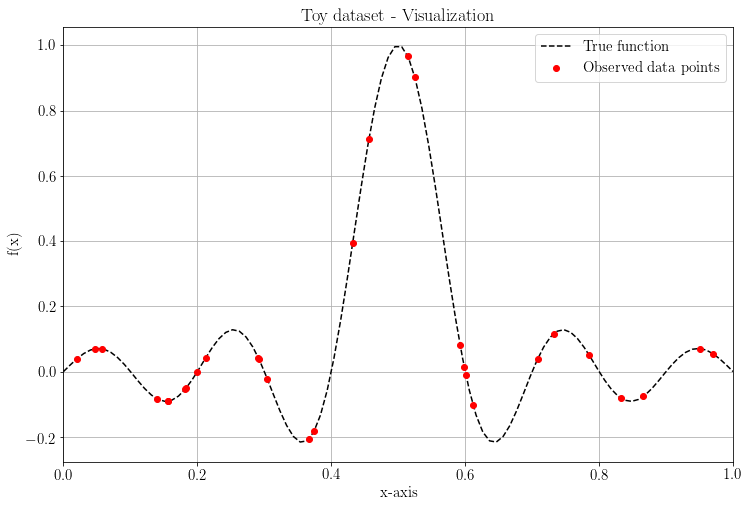

In [2]:
D = get_toy_dataset(num_points=30)
visualize_dataset(D[0], D[1])

## 2. Traning the SurrogateNN

In [17]:
model = dngo_v1.DNGO_v1(num_epochs=10000)

In [18]:
X, y = D
X = np.reshape(X, (len(X), -1))

100%|██████████| 10000/10000 [00:12<00:00, 822.24it/s]


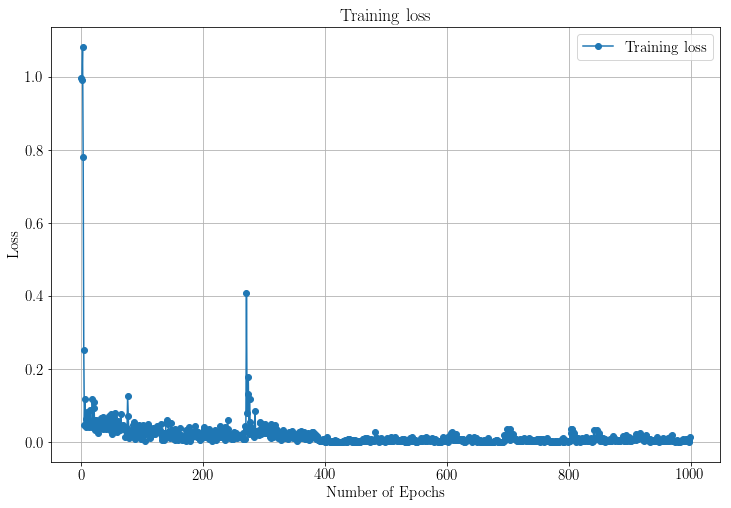

In [19]:
Theta, nn_model = model.train(X, y)

In [20]:
nn_model

NeuralNetwork(
  (fc1): Linear(in_features=1, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=1, bias=True)
)

In [21]:
Theta.shape

(30, 50)

In [22]:
from util.plotting import setup
import matplotlib.pyplot as plt

def plot_basis_functions(nn_model, X, y):
    X_test = np.linspace(0, 1, 100)
    X_test = X_test.reshape((-1, X.shape[1]))
    
    Theta_test = nn_model.basis_functions((torch.from_numpy(X_test).float())).detach().numpy()
    
    basis_funcs = []
    
    plt.figure(figsize=(12, 8))
    setup((12, 8))

    plt.title("DNGO - Visualization")
    plt.grid()
    
    plt.plot(X, y, "ro", label="Observed data points")
    plt.plot(X_test[:, 0], f(X_test[:,0]), "k--", label="True function")
    
    for i in range(Theta_test.shape[1]):
        plt.plot(X_test[:, 0], Theta_test[:, i])
    
    return Theta_test

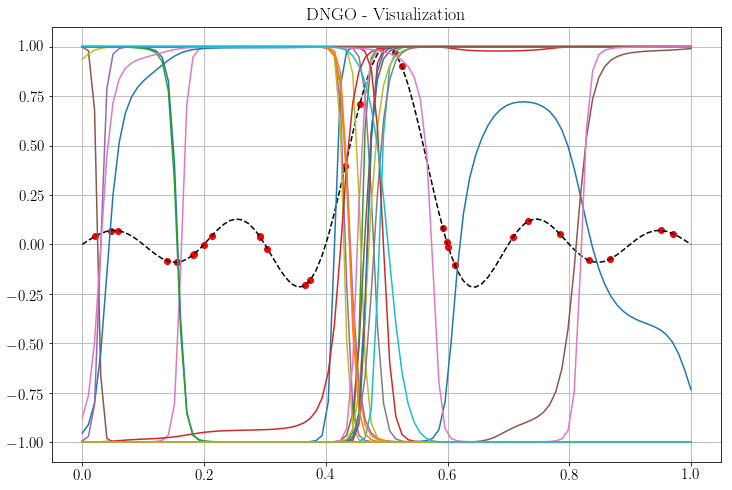

In [23]:
a = plot_basis_functions(nn_model, X, y)

In [24]:
a.shape

(100, 50)

## 3. Predictive Mean and Variance (Random BLR Hyperparameters)

In [25]:
X_test = np.linspace(0, 1, 100)
# x_test_norm, _, _ = zero_mean_unit_var_normalization(X_test[:, None], )[0]
X_test = X_test.reshape((-1, X.shape[1]))

In [26]:
alpha, beta, Gamma, c, lambda_ = 1.5, 5000, np.diag([1.0 for i in range(X.shape[1])]), [0.0], 0.0

In [27]:
mu, var = np.zeros(X_test.shape[0]), np.zeros(X_test.shape[0])

In [28]:
for i in tqdm.trange(X_test.shape[0]):
    x_test = X_test[i,:]
    mu[i], var[i] = model.predict(x_test, nn_model, X, y, Theta, alpha, beta, Gamma, c, lambda_)

100%|██████████| 100/100 [00:00<00:00, 964.13it/s]


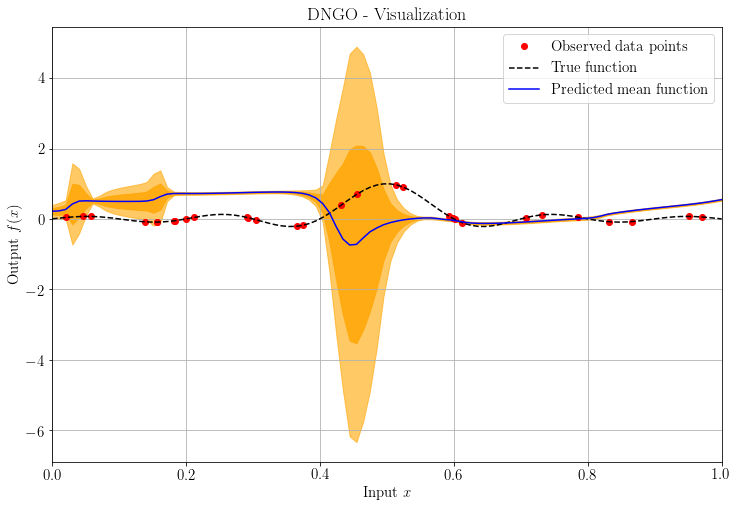

In [29]:
visualize_predictions(X, y, X_test, mu, var)

In [16]:
mu

array([-5.11632488e+00, -5.68525878e+00, -5.04523963e+00, -3.64484228e+00,
       -2.02375675e+00, -5.89062436e-01,  4.55744618e-01,  1.08037020e+00,
        1.36598951e+00,  1.44851309e+00,  1.47272860e+00,  1.55486922e+00,
        1.75566462e+00,  2.07026706e+00,  2.43997932e+00,  2.78189046e+00,
        3.02224317e+00,  3.11870399e+00,  3.06504073e+00,  2.88301716e+00,
        2.60940759e+00,  2.28448034e+00,  1.94484153e+00,  1.61992335e+00,
        1.33126839e+00,  1.09334736e+00,  9.14750663e-01,  7.99674287e-01,
        7.49012741e-01,  7.61416046e-01,  8.33783344e-01,  9.61653695e-01,
        1.13927185e+00,  1.35935617e+00,  1.61271273e+00,  1.88764372e+00,
        2.16924925e+00,  2.43869661e+00,  2.67297296e+00,  2.84541392e+00,
        2.92783567e+00,  2.89517450e+00,  2.73317672e+00,  2.44817631e+00,
        2.07508730e+00,  1.67697504e+00,  1.32922778e+00,  1.08764305e+00,
        9.52482295e-01,  8.54412370e-01,  6.94252047e-01,  4.37578657e-01,
        1.71101827e-01,  

## 4. Finding the optimal BLR Hyperparameters

In [17]:
mll_current = model.marginal_log_likelihood(Theta, X, y, alpha, beta, Gamma, c, lambda_)

In [18]:
mll_current

-12307.6452534765

In [19]:
other_params = (Theta, X, y, beta, Gamma, c, lambda_)
obj_alpha = model.objective_alpha(alpha, *other_params)

In [20]:
obj_alpha

12307.6452534765

In [21]:
init_params = Theta, X, y, alpha, beta, Gamma, c, lambda_

In [22]:
alpha_opt, beta_opt, Gamma_opt, c_opt, lambda_opt = model.alternating_optimization(init_params)

  0%|          | 0/2 [00:00<?, ?it/s]/home/piyush/Desktop/acads/8th_Semester/CS698X/BayesOpt/code/dngo_v1.py:208: RuntimeWarning: invalid value encountered in log
  self.val = ((self.D)/2.0)*np.log(alpha) + ((self.N)/2.0)*np.log(beta)
/home/piyush/Desktop/acads/8th_Semester/CS698X/BayesOpt/code/dngo_v1.py:211: RuntimeWarning: invalid value encountered in log
  self.val -= 0.5*np.log(np.linalg.det(self.K))
/home/piyush/miniconda3/envs/vision/lib/python3.6/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/piyush/Desktop/acads/8th_Semester/CS698X/BayesOpt/code/dngo_v1.py:208: RuntimeWarning: invalid value encountered in log
  self.val = ((self.D)/2.0)*np.log(alpha) + ((self.N)/2.0)*np.log(beta)
/home/piyush/Desktop/acads/8th_Semester/CS698X/BayesOpt/code/dngo_v1.py:211: RuntimeWarning: invalid value encountered in log
  self.val -= 0.5*np.log(np.linalg.det(self.K))
/home/piyush/Desktop/acads/8th_Sem

In [23]:
alpha_opt

array([-1032.74])

In [24]:
beta_opt

array([5000.])

In [25]:
Gamma_opt

array([[0.4]])

In [26]:
c_opt

array([0.01])

In [27]:
lambda_opt

array([40.])

## 5. Predictive Mean and Variance (*Optimal* BLR Hyperparameters)

In [28]:
X_test = np.linspace(0, 1, 100)
X_test = X_test.reshape((-1, X.shape[1]))

alpha, beta, Gamma, c, lambda_ = alpha_opt[0], beta_opt[0], Gamma_opt[0], c_opt[0], lambda_opt[0]

In [29]:
mu, var = np.zeros(X_test.shape[0]), np.zeros(X_test.shape[0])

for i in tqdm.trange(X_test.shape[0]):
    x_test = X_test[i,:]
    mu[i], var[i] = model.predict(x_test, nn_model, X, y, Theta, alpha, beta, Gamma, c, lambda_)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence.

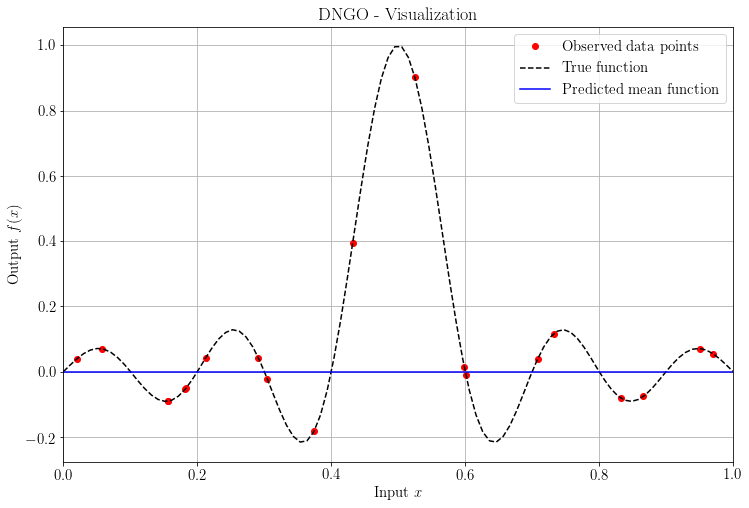

In [25]:
visualize_predictions(X, y, X_test, mu, var)

In [26]:
alpha

-1033.24

In [24]:
model.predict([0.0], nn_model, X, y, Theta, alpha, beta, Gamma, c, lambda_)

(array([-0.50097328, -0.26706415, -0.22518039, -0.31986146, -0.41661862,
        -0.4166249 , -0.26788505, -0.40277852, -0.34265992, -0.29690521,
        -0.29540167, -0.28159561, -0.40797031, -0.29371395, -0.3825219 ,
        -0.37882398, -0.3524595 ,  0.50304351,  0.03286634, -0.29403448]),
 0.001342879144728579)

## 6. Bayesian Optimization Routine

In [30]:
def find_x_best(X_test):
    f_x_test = np.array([f(x[0]) for x in X_test])
    return X_test[np.argmin(f_x_test)]

def g(x, x_best, mu_x, sigma_x):
    return np.divide(f(x_best) - mu_x, sigma_x)

def alpha_EI(x, g_x, sigma_x):
    a = norm.cdf(g_x)
    b = norm.pdf(g_x)
    return sigma_x*(g_x*a + b)

In [31]:
x_best = find_x_best(X_test)

In [32]:
g_X_test = [g(X_test[i], x_best, mu[i], np.sqrt(var[i])) for i in range(X_test.shape[0])]

/home/piyush/miniconda3/envs/vision/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [33]:
EI = [alpha_EI(X_test[i], g_X_test[i], np.sqrt(var[i])) for i in range(X_test.shape[0])]

/home/piyush/miniconda3/envs/vision/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


<Figure size 1080x1008 with 0 Axes>

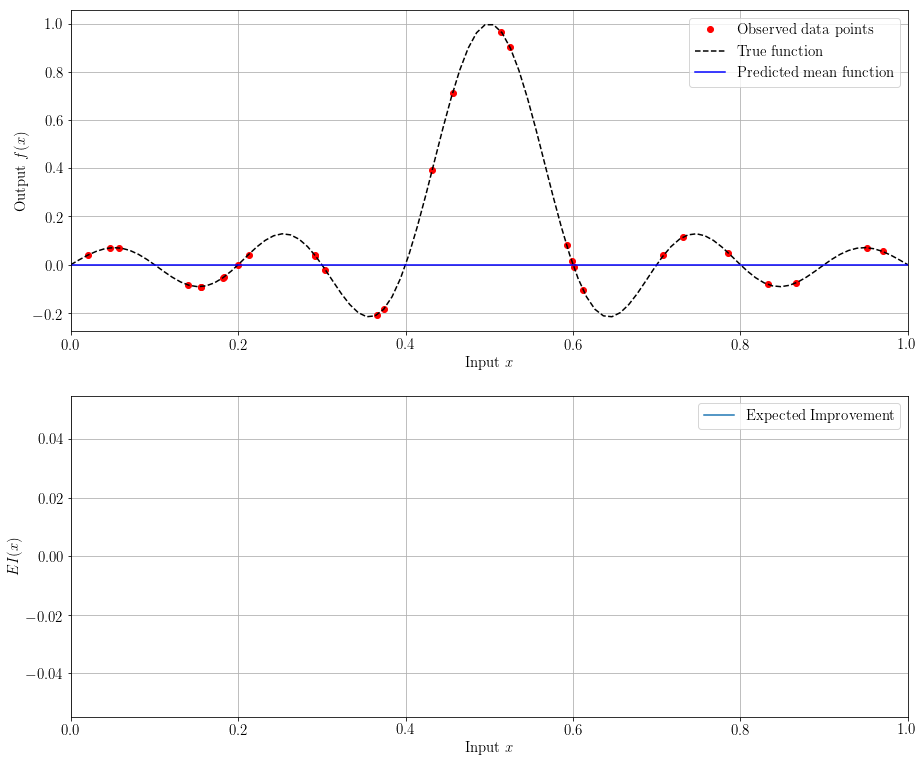

In [34]:
a = visualize_EI(X, y, X_test, mu, var, EI)

In [35]:
x_new = X_test[np.argmax(EI)]

In [36]:
x_new

array([0.])

In [37]:
y_new = f(x_new)

In [38]:
y_new

array([3.89817183e-17])

In [39]:
X

array([[0.37454012],
       [0.95071431],
       [0.73199394],
       [0.59865848],
       [0.15601864],
       [0.15599452],
       [0.05808361],
       [0.86617615],
       [0.60111501],
       [0.70807258],
       [0.02058449],
       [0.96990985],
       [0.83244264],
       [0.21233911],
       [0.18182497],
       [0.18340451],
       [0.30424224],
       [0.52475643],
       [0.43194502],
       [0.29122914],
       [0.61185289],
       [0.13949386],
       [0.29214465],
       [0.36636184],
       [0.45606998],
       [0.78517596],
       [0.19967378],
       [0.51423444],
       [0.59241457],
       [0.04645041]])

## 7. Updating the posterior

In [40]:
X = np.append(X, np.array([x_new[0]]))

In [41]:
X = X.reshape((-1, 1))

In [42]:
X.shape

(31, 1)

In [43]:
y = np.append(y, y_new)

In [44]:
y.shape

(31,)

100%|██████████| 1000/1000 [00:01<00:00, 930.61it/s]


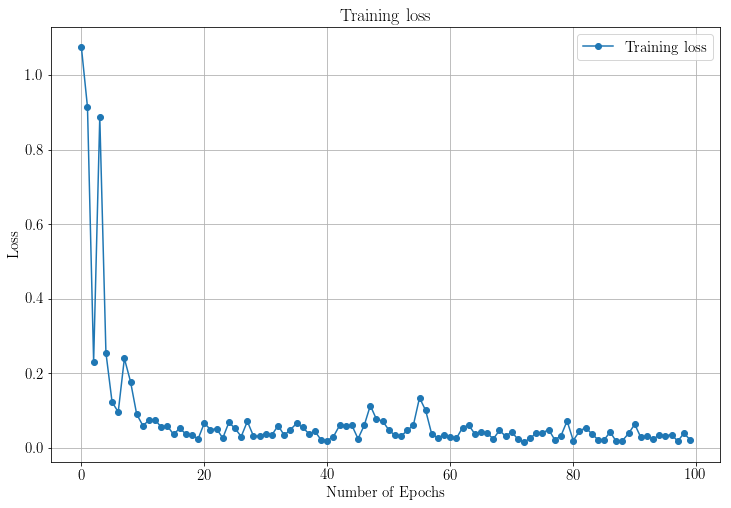

100%|██████████| 100/100 [00:00<00:00, 1399.11it/s]


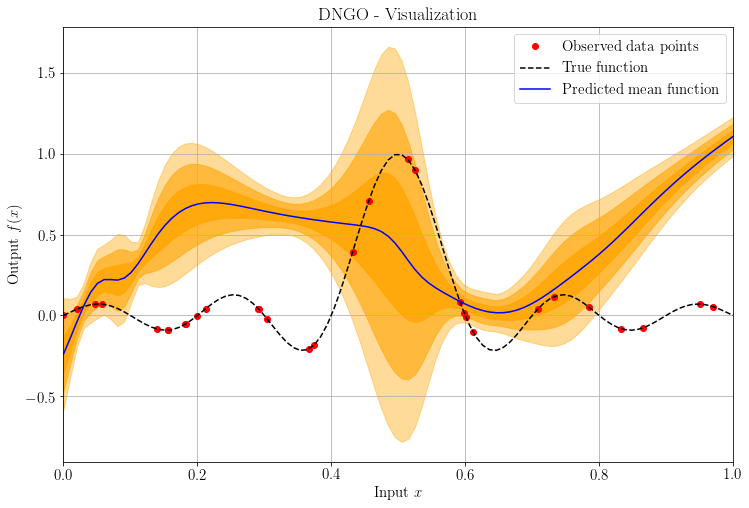

<Figure size 1080x1008 with 0 Axes>

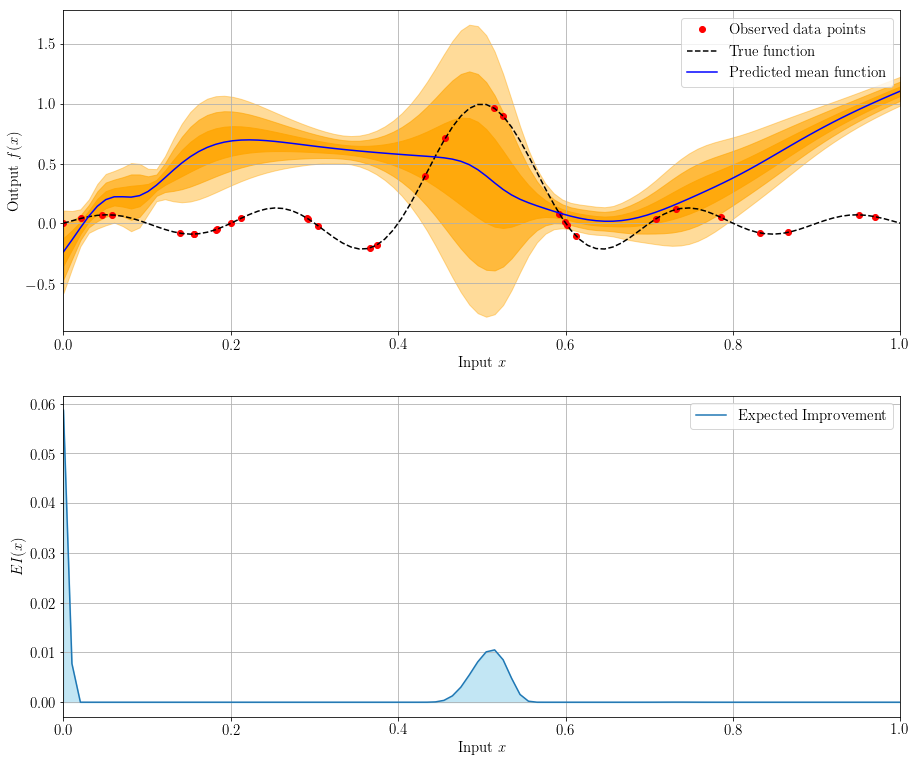

In [45]:
Theta, nn_model = model.train(X, y)

## 3. Predictive Mean and Variance (Random BLR Hyperparameters)

X_test = np.linspace(0, 1, 100)
X_test = X_test.reshape((-1, X.shape[1]))

alpha, beta, Gamma, c, lambda_ = 1.0, 1000.0, np.diag([2 for i in range(X.shape[1])]), X_test[0], 0.05

mu, var = np.zeros(X_test.shape[0]), np.zeros(X_test.shape[0])

for i in tqdm.trange(X_test.shape[0]):
    x_test = X_test[i,:]
    mu[i], var[i] = model.predict(x_test, nn_model, X, y, Theta, alpha, beta, Gamma, c, lambda_)

visualize_predictions(X, y, X_test, mu, var)

x_best = find_x_best(X_test)

g_X_test = [g(X_test[i], x_best, mu[i], np.sqrt(var[i])) for i in range(X_test.shape[0])]

EI = [alpha_EI(X_test[i], g_X_test[i], np.sqrt(var[i])) for i in range(X_test.shape[0])]

a = visualize_EI(X, y, X_test, mu, var, EI)

In [30]:
X = np.append(X, np.array([x_new[0]]))

X = X.reshape((-1, 1))

X.shape

y = np.append(y, y_new)

y.shape

(22,)

100%|██████████| 10000/10000 [00:11<00:00, 907.00it/s]


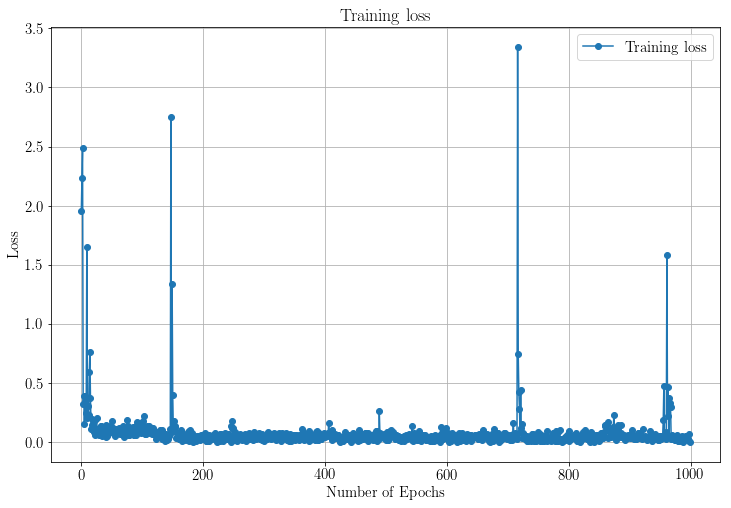

100%|██████████| 100/100 [00:00<00:00, 1246.82it/s]


<Figure size 1080x1008 with 0 Axes>

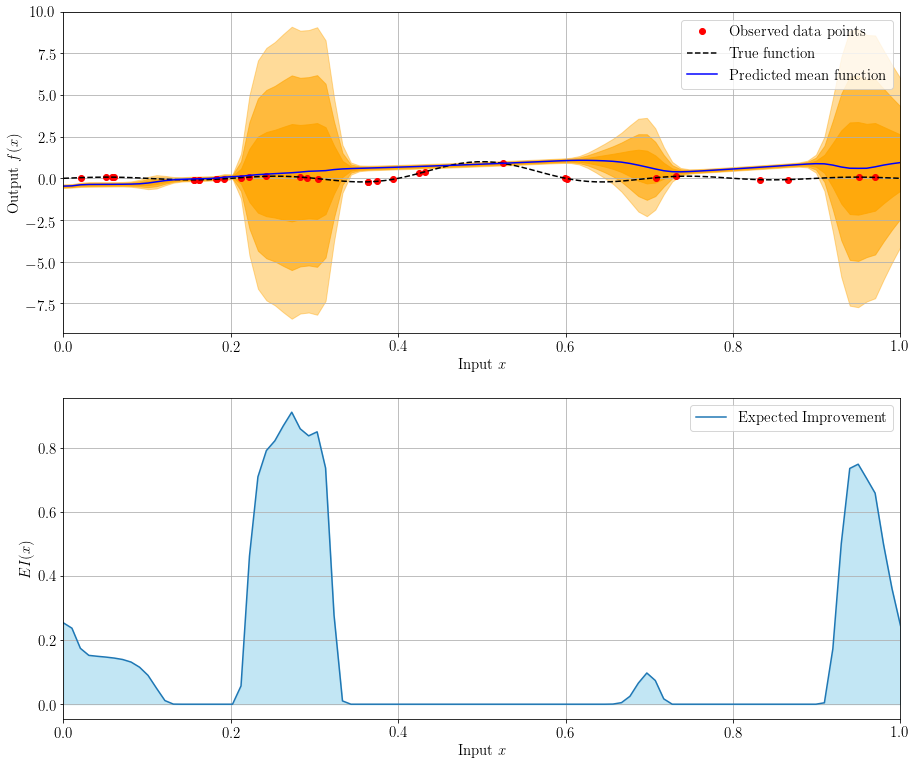

100%|██████████| 10000/10000 [00:12<00:00, 806.52it/s]


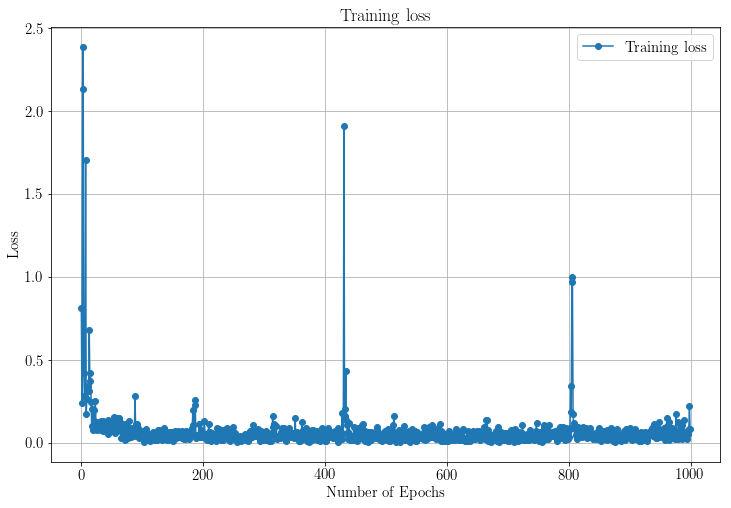

100%|██████████| 100/100 [00:00<00:00, 1190.75it/s]


<Figure size 1080x1008 with 0 Axes>

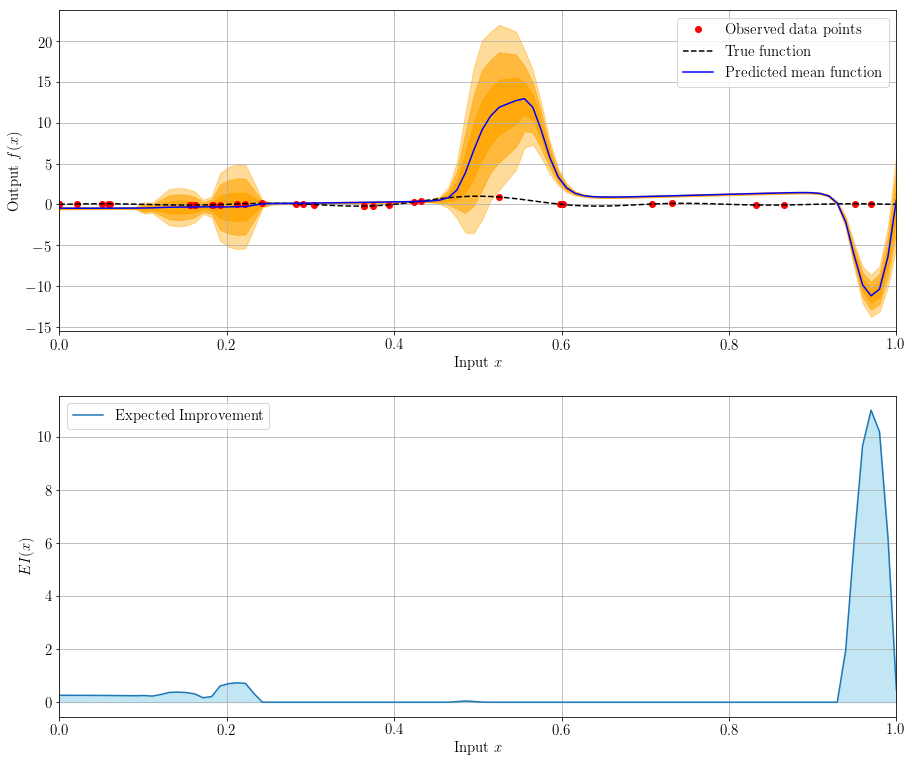

100%|██████████| 10000/10000 [00:13<00:00, 743.92it/s]


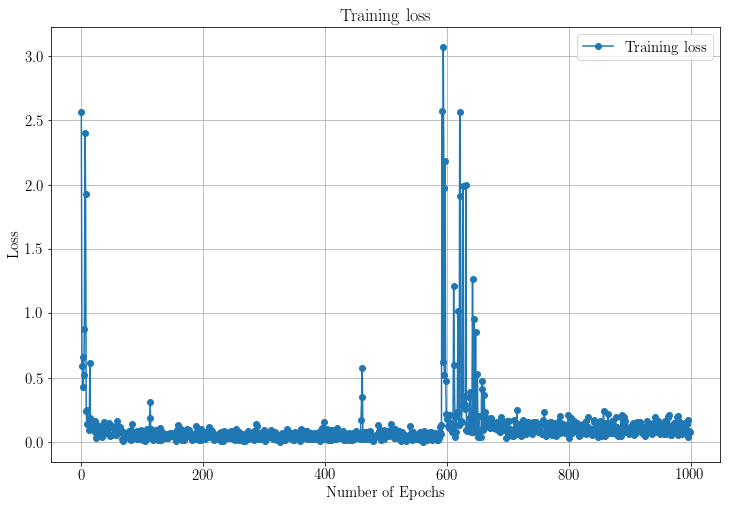

100%|██████████| 100/100 [00:00<00:00, 940.55it/s]


<Figure size 1080x1008 with 0 Axes>

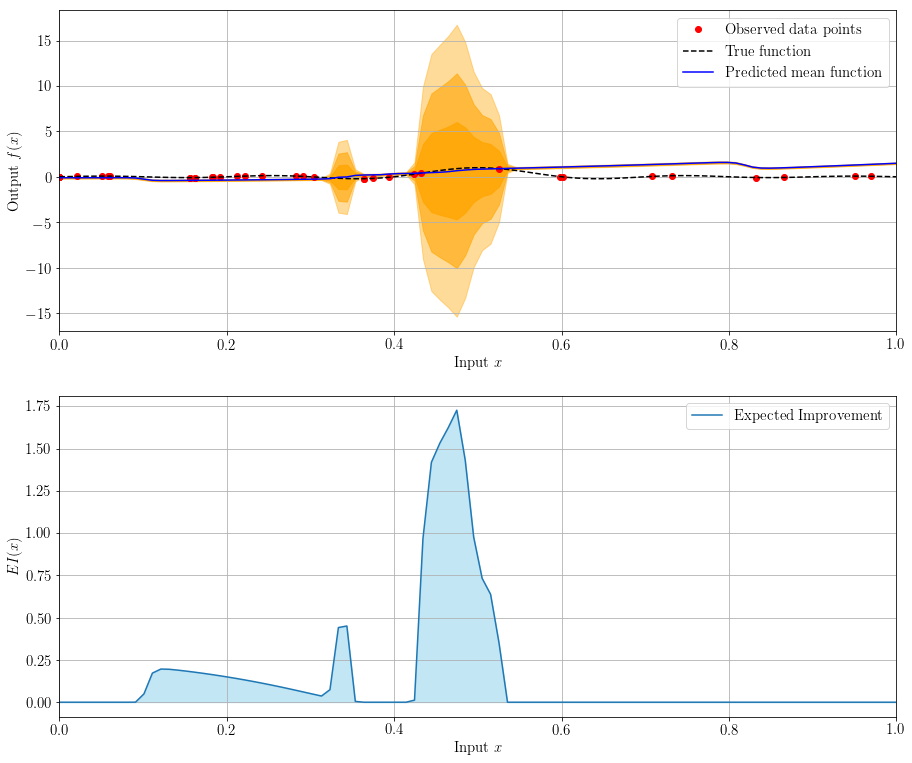

100%|██████████| 10000/10000 [00:14<00:00, 825.69it/s]


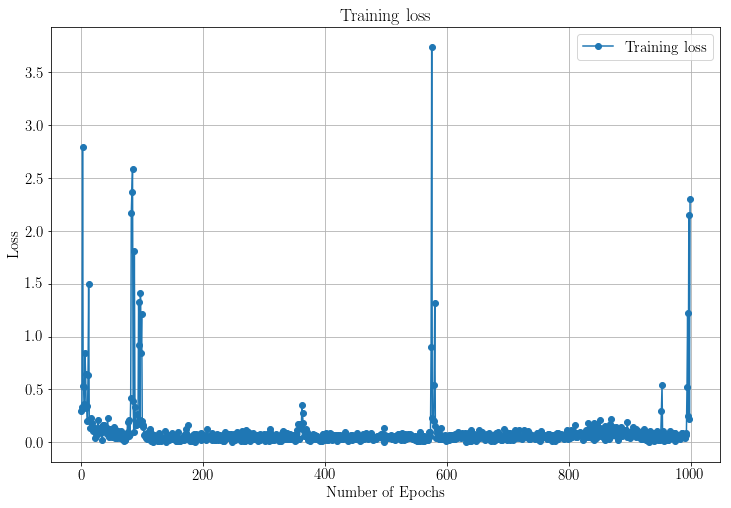

100%|██████████| 100/100 [00:00<00:00, 1063.66it/s]


<Figure size 1080x1008 with 0 Axes>

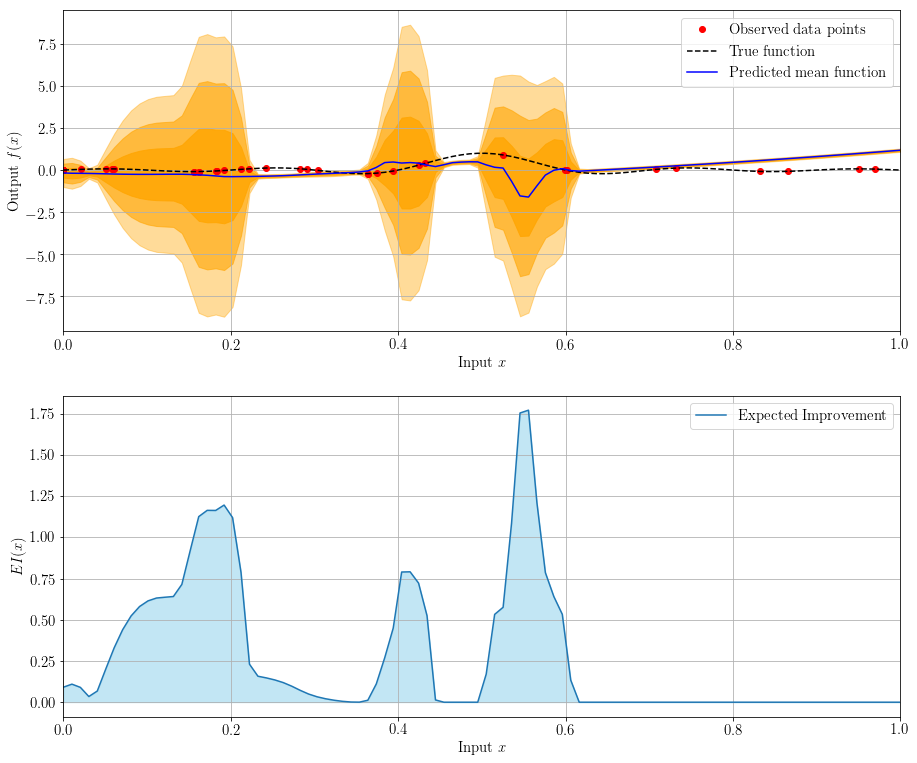

100%|██████████| 10000/10000 [00:12<00:00, 772.86it/s]


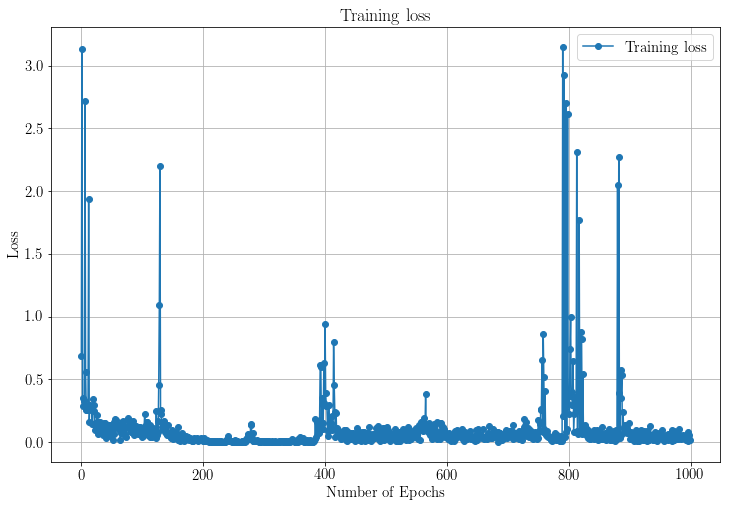

100%|██████████| 100/100 [00:00<00:00, 831.05it/s]


<Figure size 1080x1008 with 0 Axes>

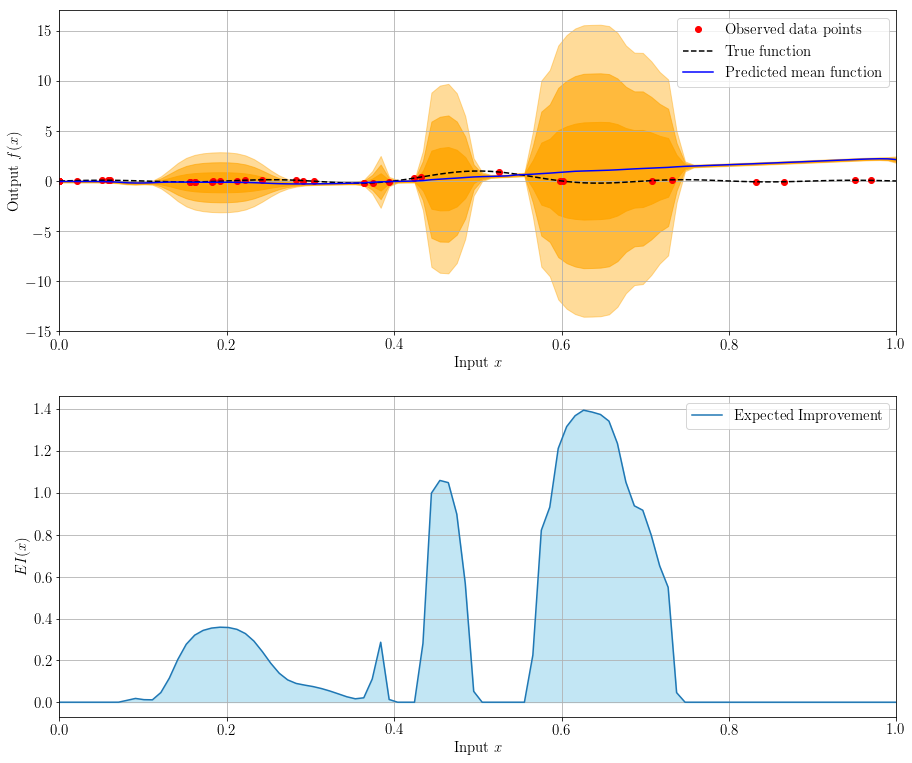

100%|██████████| 10000/10000 [00:14<00:00, 703.95it/s]


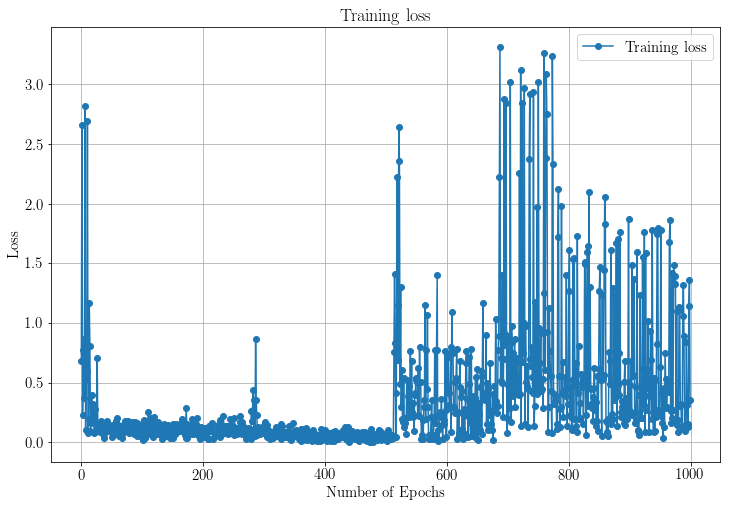

100%|██████████| 100/100 [00:00<00:00, 1122.40it/s]


<Figure size 1080x1008 with 0 Axes>

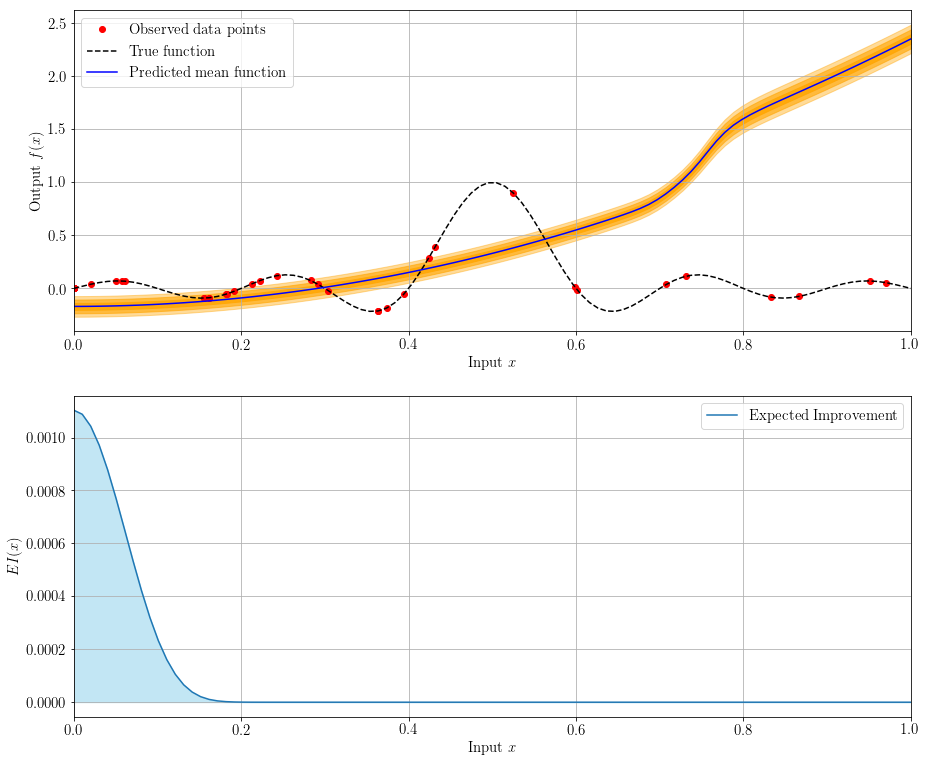

100%|██████████| 10000/10000 [00:13<00:00, 727.00it/s]


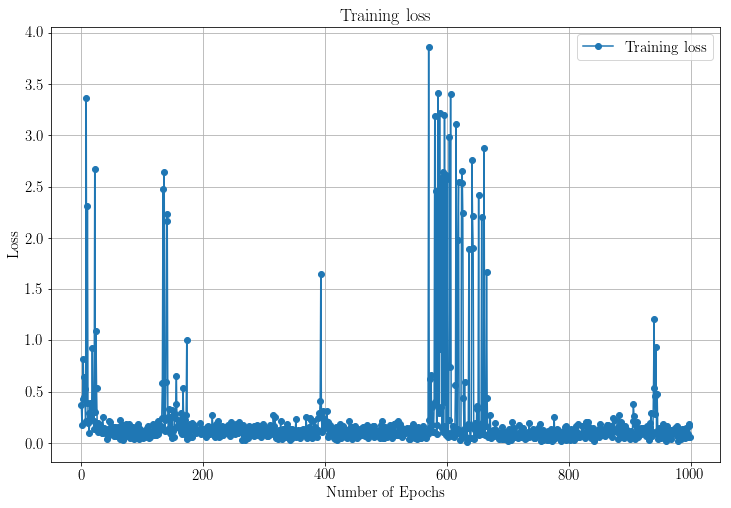

100%|██████████| 100/100 [00:00<00:00, 1083.88it/s]


<Figure size 1080x1008 with 0 Axes>

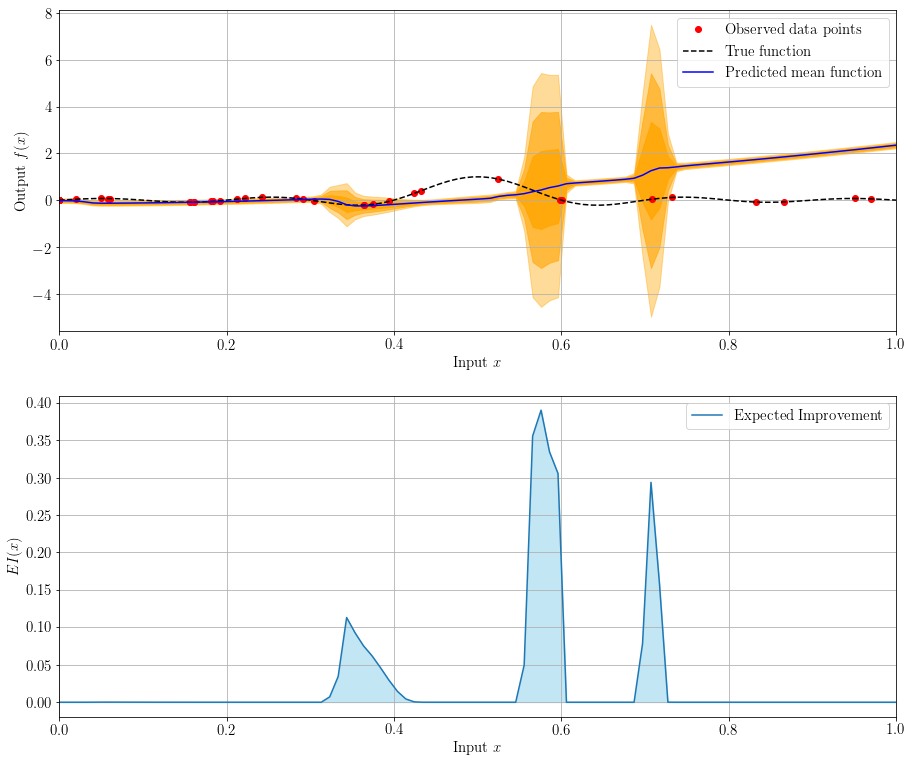

100%|██████████| 10000/10000 [00:13<00:00, 733.73it/s]


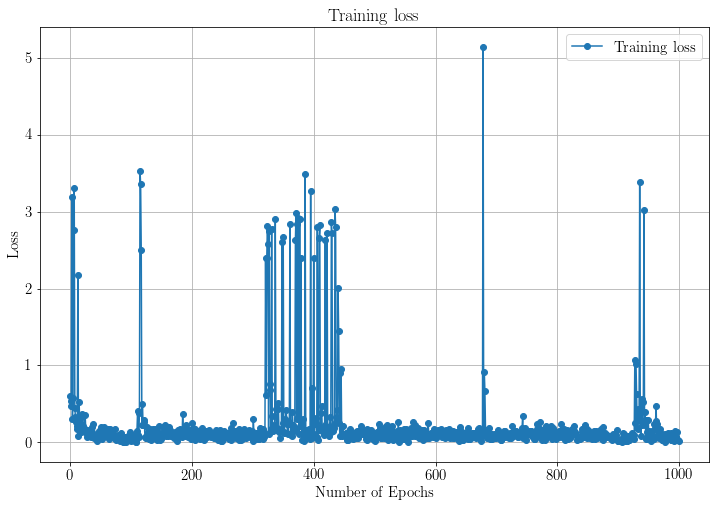

100%|██████████| 100/100 [00:00<00:00, 765.99it/s]


<Figure size 1080x1008 with 0 Axes>

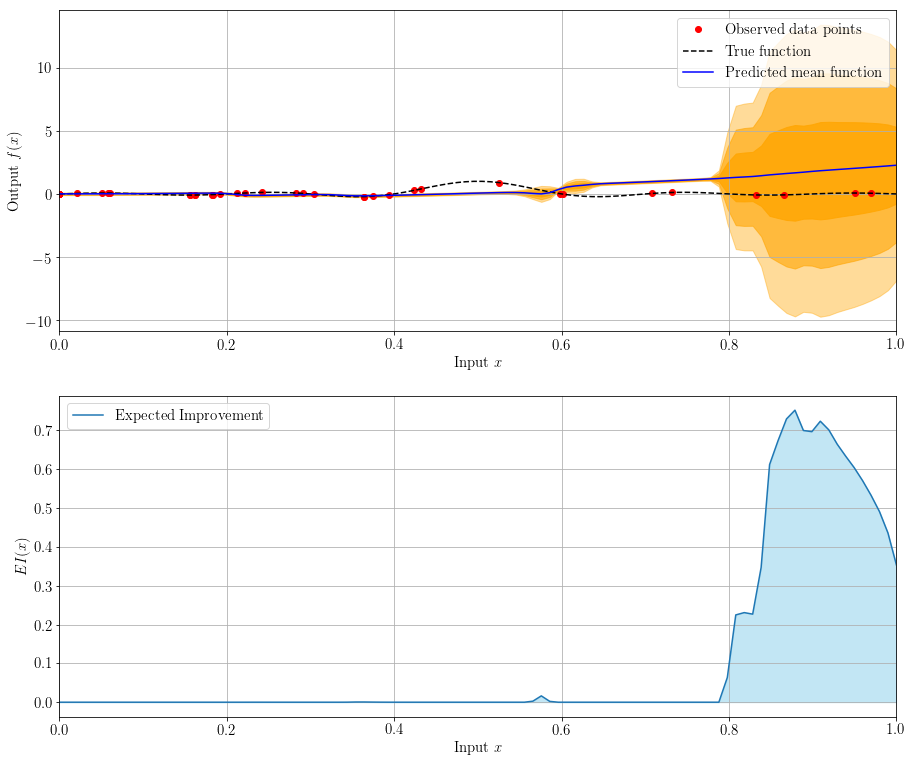

100%|██████████| 10000/10000 [00:13<00:00, 735.93it/s]


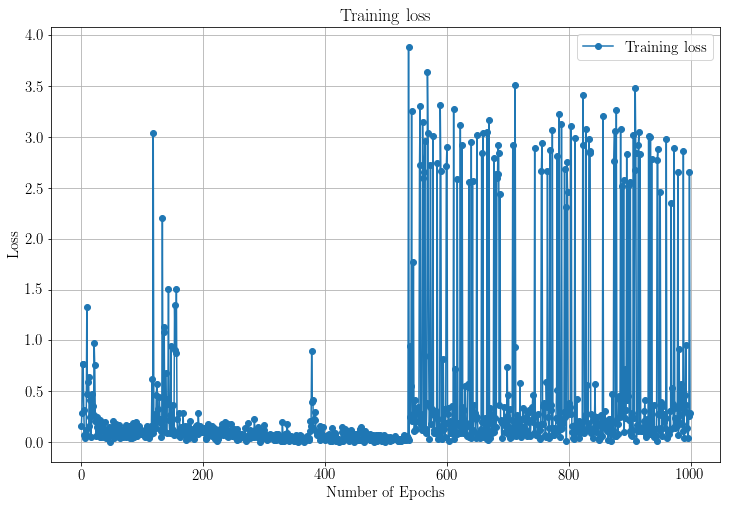

100%|██████████| 100/100 [00:00<00:00, 781.09it/s]


<Figure size 1080x1008 with 0 Axes>

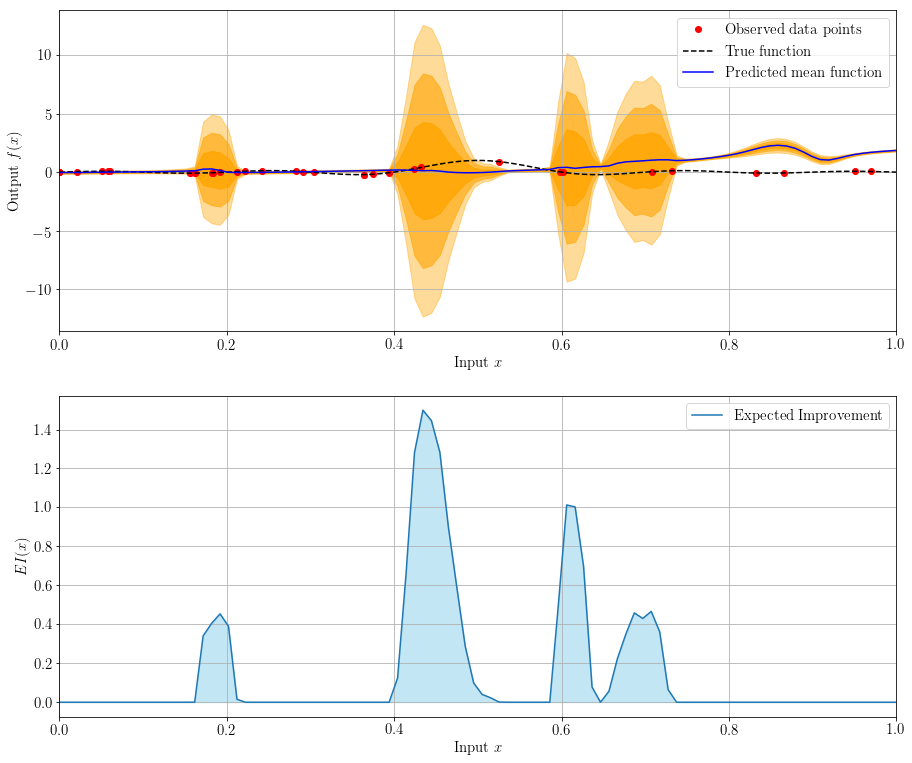

100%|██████████| 10000/10000 [00:13<00:00, 766.68it/s]


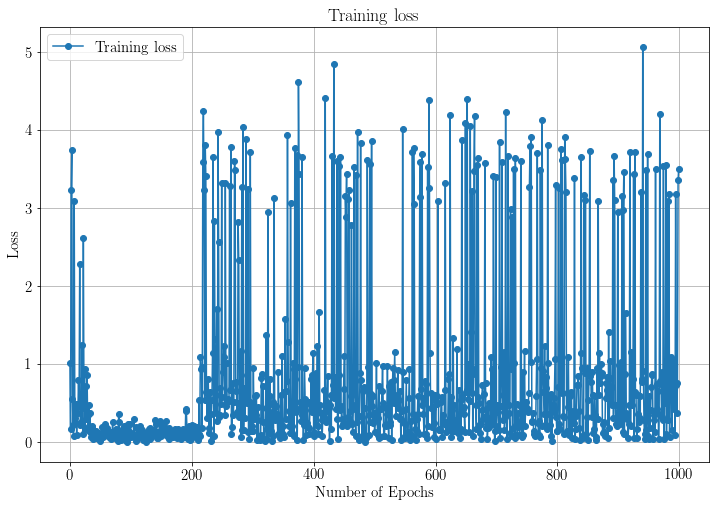

100%|██████████| 100/100 [00:00<00:00, 1035.03it/s]


<Figure size 1080x1008 with 0 Axes>

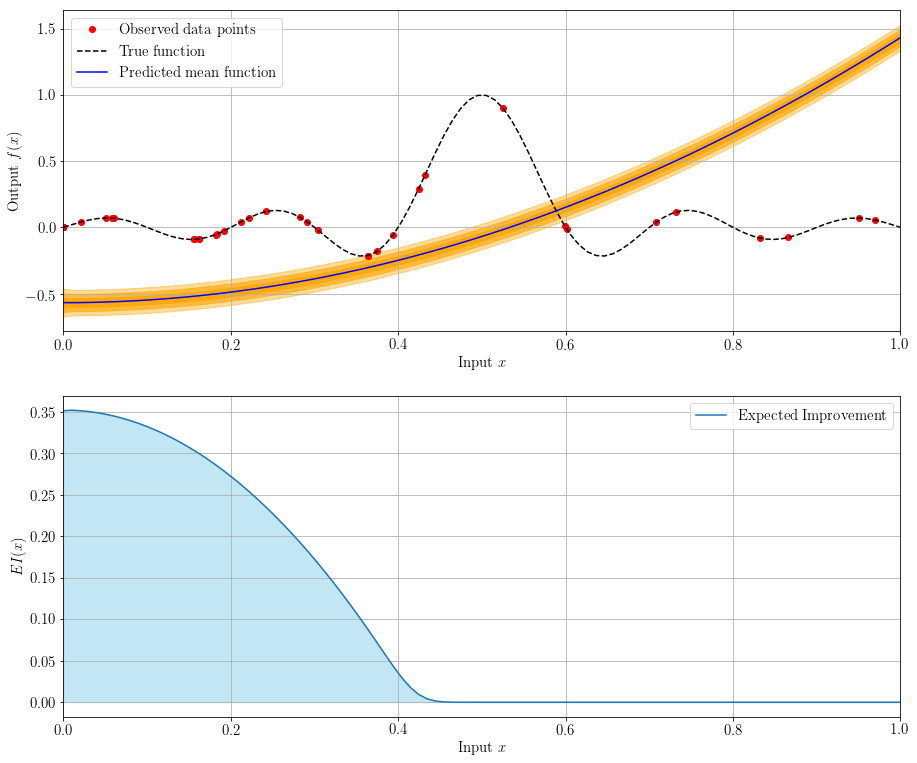

In [32]:
for i in range(10):
    Theta, nn_model = model.train(X, y)

    alpha, beta, Gamma, c, lambda_ = 1.0, 1000.0, np.diag([2 for i in range(X.shape[1])]), X_test[0], 0.05

    mu, var = np.zeros(X_test.shape[0]), np.zeros(X_test.shape[0])

    for i in tqdm.trange(X_test.shape[0]):
        x_test = X_test[i,:]
        mu[i], var[i] = model.predict(x_test, nn_model, X, y, Theta, alpha, beta, Gamma, c, lambda_)

    x_best = find_x_best(X_test)

    g_X_test = [g(X_test[i], x_best, mu[i], np.sqrt(var[i])) for i in range(X_test.shape[0])]

    EI = [alpha_EI(X_test[i], g_X_test[i], np.sqrt(var[i])) for i in range(X_test.shape[0])]

    a = visualize_EI(X, y, X_test, mu, var, EI)
    
    idx = np.argsort(EI)
    X_new = [X_test[i] for i in idx[:3]]
    Y_new = [f(x) for x in X_new]
    X = np.append(X, X_new)
    X = X.reshape((-1,1))
#     x_new = X_test[np.argmax(EI)]
#     y_new = f(x_new)
#     X = np.append(X, np.array([x_new[0]]))
#     X = X.reshape((-1, 1))
    y = np.append(y, Y_new)